In [1]:
import gym
import itertools
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
from lib import plotting

from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
env = gym.make('Acrobot-v1')

In [3]:
env.observation_space.sample()

array([-2.5960734e-01,  5.6000072e-01, -1.7258802e-01, -3.7211448e-01,
        4.8584691e-03, -1.7885653e+01], dtype=float32)

In [4]:
class TileCoder:
    
    def __init__(self, tiles_per_dim, value_limits, tilings, offset=lambda n: 2 * np.arange(n) + 1):
        tiling_dims = np.array(np.ceil(tiles_per_dim), dtype=np.int) + 1
        self._offsets = offset(len(tiles_per_dim)) * \
          np.repeat([np.arange(tilings)], len(tiles_per_dim), 0).T / float(tilings) % 1
        self._limits = np.array(value_limits)
        self._norm_dims = np.array(tiles_per_dim) / (self._limits[:, 1] - self._limits[:, 0])
        self._tile_base_ind = np.prod(tiling_dims) * np.arange(tilings)
        self._hash_vec = np.array([np.prod(tiling_dims[0:i]) for i in range(len(tiles_per_dim))])
        self._n_tiles = tilings * np.prod(tiling_dims)
  
    def __getitem__(self, x):
        off_coords = ((x - self._limits[:, 0]) * self._norm_dims + self._offsets).astype(int)
        return self._tile_base_ind + np.dot(off_coords, self._hash_vec)

    @property
    def n_tiles(self):
        return self._n_tiles

In [5]:
class Function_Approximator():
    
    def __init__(self):
        tiles_per_dim = [2,2,2,2,8,18]
        lims = [(-1.0,1.0),(-1.0,1.0),(-1.0,1.0),(-1.0,1.0),(-4*np.pi,4*np.pi),(-9*np.pi,9*np.pi)]
        tilings = 8
        self.T = TileCoder(tiles_per_dim, lims, tilings)
        self.q0 = np.zeros(self.T.n_tiles)
        self.q1 = np.zeros(self.T.n_tiles)
        self.q2 = np.zeros(self.T.n_tiles)
        self.alpha_sgd = 0.1/tilings
        
    def predict(self,state):
        
        tiles = self.T[state]
        val_q0 = self.q0[tiles].sum()
        val_q1 = self.q1[tiles].sum()
        val_q2 = self.q2[tiles].sum()
        
        return np.array([val_q0,val_q1,val_q2])
    
    def update(self,state,action,target):
        
        tiles = self.T[state]
        if action == 0:
            self.q0[tiles] += self.alpha_sgd*(target-self.predict(state)[0])
        elif action == 1:
            self.q1[tiles] += self.alpha_sgd*(target-self.predict(state)[1])                                             
        elif action == 2:
            self.q2[tiles] += self.alpha_sgd*(target-self.predict(state)[2])        

In [6]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [7]:
def sarsa(env, estimator, num_episodes, alpha=1, discount_factor=0.99, epsilon=0.1, epsilon_decay=1.0):
    
#     alpha = 1
    
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
        
        policy = make_epsilon_greedy_policy(estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Initialize 's'
        state = env.reset()
        

            
        for t in itertools.count():
            
            # Choose 'a' from 's' using policy derived from Q
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            # Take action 'a' and observe r, s'
            next_state, reward, end, _ = env.step(action)
            env.render()
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Get Q(s,~)
            q_values_this = estimator.predict(state)
            
            # Get Q(s',~)
            q_values_next = estimator.predict(next_state)
            
            # [r + gamma*Q(s',a')]
            td_target = alpha*(reward + discount_factor * np.amax(q_values_next)) + (1-alpha)*q_values_this[action]
            
            # Update Q value
            estimator.update(state, action, td_target)
                
            if end:
                break
                
            state = next_state
            
        if (i_episode+1) % 10 == 0:
            avg_reward = np.sum(stats.episode_rewards[i_episode-10:i_episode])/10
            print("\rEpisode {}/{} Avg. reward = {}".format(i_episode + 1, num_episodes, avg_reward))
    
    return stats

In [8]:
path="/home/shiladitya/Desktop/CartPole3D_RL-master/Exp_data_QLearn_Tiling/" # Just change the path here

estimator = Function_Approximator()

# Initialize Parameters 
discount_factor=0.99
epsilon=0.1
epsilon_decay=1.0
alpha=1
N_episod=100
f_name="/N_ep= "+str(N_episod)+" Dis_fact= "+str(discount_factor)+" Epsi: "+str(epsilon)+" dcay: "+str(epsilon_decay)+" alpha: "+str(alpha)

stats = sarsa(env, estimator, N_episod, alpha, discount_factor, epsilon, epsilon_decay)
np.save(path+f_name,stats)


Episode 10/100 Avg. reward = 0.0
Episode 20/100 Avg. reward = -392.5
Episode 30/100 Avg. reward = -287.1
Episode 40/100 Avg. reward = -331.7
Episode 50/100 Avg. reward = -270.1
Episode 60/100 Avg. reward = -311.3
Episode 70/100 Avg. reward = -260.9
Episode 80/100 Avg. reward = -283.8
Episode 90/100 Avg. reward = -228.1
Episode 100/100 Avg. reward = -208.2


In [ ]:
# Fisrt row -> Episode Length
# Second row -> Episode Reward
np.load('Exp_data_QLearn_Tiling/N_ep= 500 Dis_fact= 0.99 Epsi: 0.1 DK: 1.0 alpha: 1.npy')

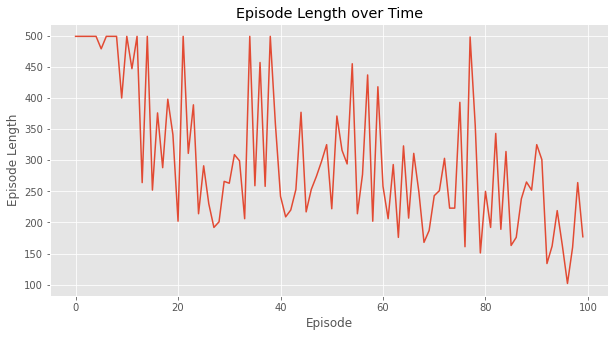

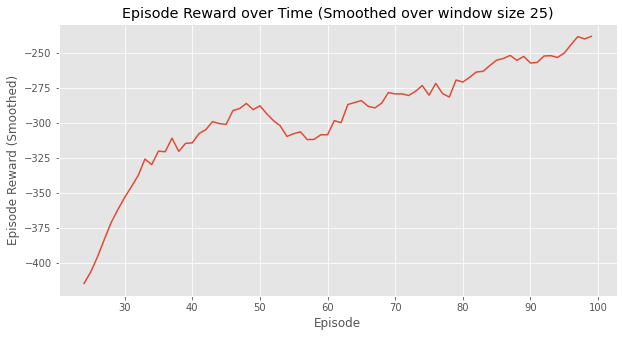

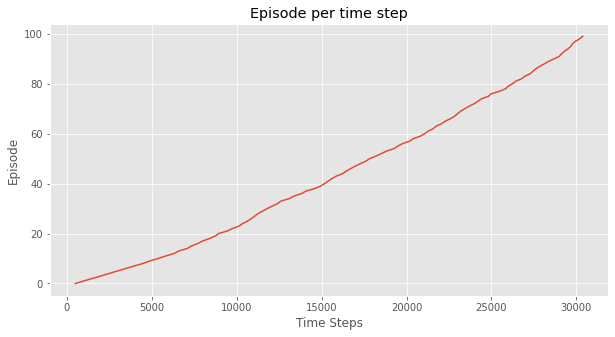

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [9]:
plotting.plot_episode_stats(stats, smoothing_window=25)

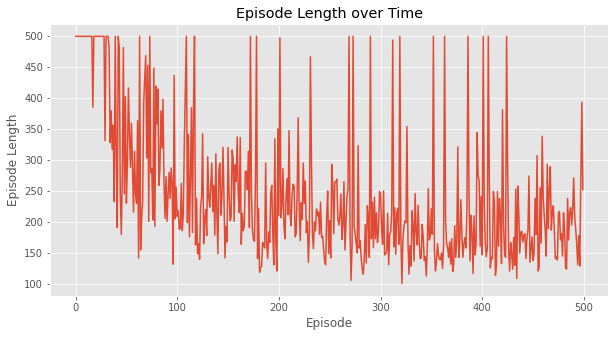

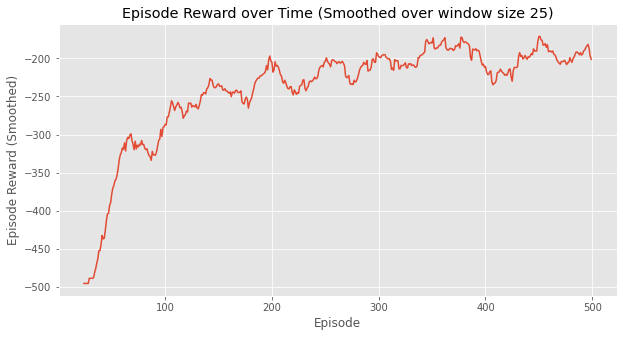

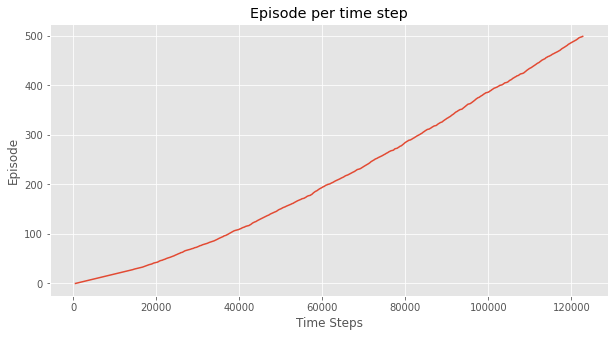

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [19]:
plotting.plot_episode_stats(stats, smoothing_window=25)

In [28]:
# state = env.observation_space.sample()
state = env.reset()
# plt.figure()
# plt.imshow(env.render(mode='rgb_array'))
while True:
    q_values = estimator.predict(state)
    best_action = np.argmax(q_values)
#     plt.figure()
#     plt.imshow(env.render(mode='rgb_array'))

#     action_pge = get_pge_action(best_action)
    
    next_state, reward, end, _ = env.step(best_action)
    if end:
        break
        
    state = next_state
    env.render()
# env.close()

In [63]:
env.observation_space.sample()

array([-0.11945403,  0.29413375, -1.4568335 , -0.17493604,  0.40899193,
        0.73602676,  1.3300323 ,  0.1892223 ], dtype=float32)

In [31]:
env = gym.make('CartPole-v1')

In [61]:
env.reset()
env.step(env.action_space.sample())

(array([ 0.00353907,  0.19214232, -0.0343606 , -0.34522076]), 1.0, False, {})

In [123]:
env.step(env.action_space.sample())

(array([-0.74117499, -1.35688824,  0.28442935,  1.79704102]), 0.0, True, {})

In [29]:
env.close()